# Lung Segmentation from Chest X-Ray using U-Net

## Import libraries

In [ ]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from glob import glob
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/LungSegmentationData'
%pwd

/content/drive/MyDrive/LungSegmentationData


'/content/drive/MyDrive/LungSegmentationData'

## Data Preparation

In [ ]:
INPUT_C_DIR = os.path.join("..", "input_c")
INPUT_DIR = os.path.join("..", "LungSegmentationData")

SEGMENTATION_DIR = os.path.join(INPUT_C_DIR, "segmentation")
SEGMENTATION_TEST_DIR = os.path.join(SEGMENTATION_DIR, "test")
SEGMENTATION_TRAIN_DIR = os.path.join(SEGMENTATION_DIR, "train")
SEGMENTATION_AUG_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "augmentation")
SEGMENTATION_IMAGE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "image")
SEGMENTATION_MASK_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "mask")
SEGMENTATION_onlylung_DIR = os.path.join(SEGMENTATION_DIR, "onlylung")
SEGMENTATION_SOURCE_DIR = os.path.join(INPUT_DIR)

SHENZHEN_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR, "ChinaSet_AllFiles", "ChinaSet_AllFiles")
SHENZHEN_IMAGE_DIR = os.path.join(SHENZHEN_TRAIN_DIR, "CXR_png")
SHENZHEN_MASK_DIR = os.path.join(INPUT_DIR, "mask", "mask")

Fuction for visualization

In [ ]:
def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret



Write Image data to directory

In [ ]:
shenzhen_mask_dir = glob(os.path.join(SHENZHEN_MASK_DIR, '*.png'))
shenzhen_train= shenzhen_mask_dir[:]

'for mask_file in tqdm(shenzhen_mask_dir[:200]):\n    base_file = os.path.basename(mask_file).replace("_mask", "")\n    image_file = os.path.join(SHENZHEN_IMAGE_DIR, base_file)\n\n    image = cv2.imread(image_file)\n    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)\n\n    image = cv2.resize(image, (512, 512))\n    mask = cv2.resize(mask, (512, 512))\n\n    if (mask_file in shenzhen_train):\n        cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file),                     image)\n        cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file),                     mask)\n    else:\n        filename, fileext = os.path.splitext(base_file)\n\n        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file),                     image)\n        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR,                                  "%s_mask%s" % (filename, fileext)), mask)'

Visualize Image, Mask, Merged image

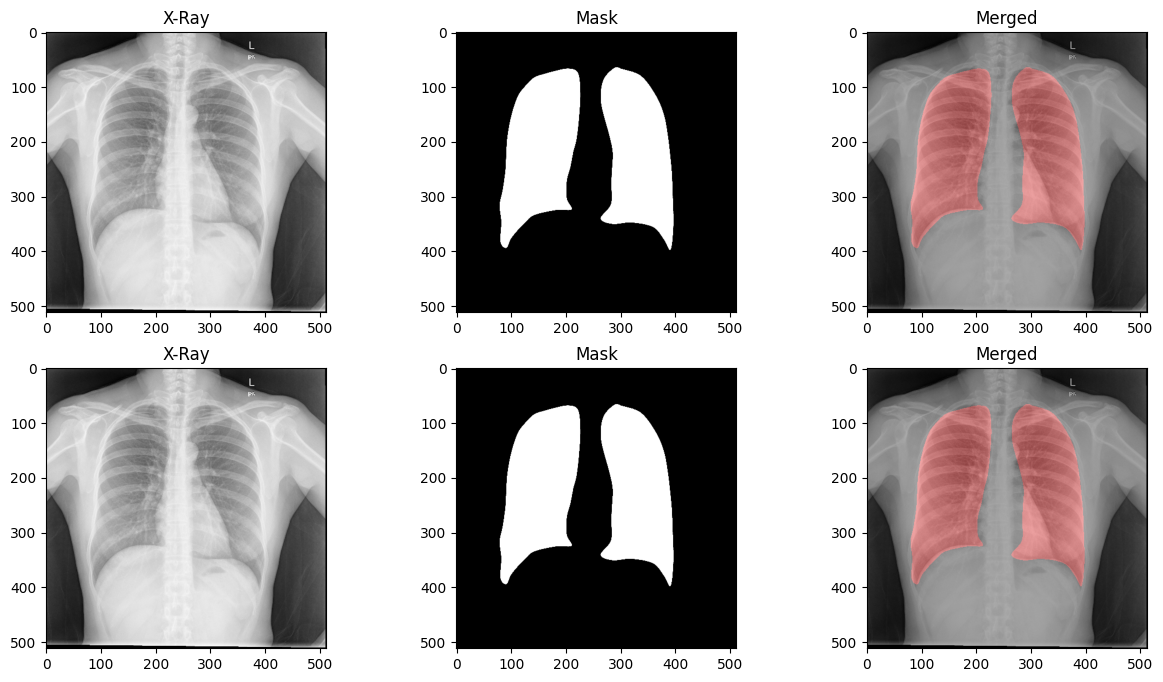

In [ ]:
base_file = os.path.basename(shenzhen_train[0].replace("_mask", ""))

image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
merged_image = add_colored_mask(image, mask_image)

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Merged")
axs[0, 2].imshow(merged_image)

base_file = os.path.basename(shenzhen_test[0].replace("_mask", ""))
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
filename, fileext = os.path.splitext(base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
merged_image = add_colored_mask(image, mask_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Merged")
axs[1, 2].imshow(merged_image)

In [ ]:
train_files = glob(os.path.join(SEGMENTATION_IMAGE_DIR, "*.png"))
test_files = glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png"))
mask_files = glob(os.path.join(SEGMENTATION_MASK_DIR, "*.png"))

(len(train_files), \
 len(test_files), \
 len(mask_files))

(566, 200, 566)

Metric Evaluation

# VGG16



---
https://www.kaggle.com/code/basu369victor/transferlearning-and-unet-to-segment-rocks-on-moon/notebook


---





In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras.applications import vgg16
from keras.models import Model,load_model
import keras
from keras.layers import Input, Conv2D, Conv2DTranspose,AveragePooling2D, MaxPooling2D,UpSampling2D,LeakyReLU, concatenate, Dropout,BatchNormalization,Activation
from keras.callbacks import EarlyStopping,ModelCheckpoint
import pandas as pd
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from numpy.random import seed
seed(123)
import tensorflow as tf
tf.random.set_seed(123)
from keras import backend as K
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)
#print(os.listdir("../input/"))
#InputPath = "../input/artificial-lunar-rocky-landscape-dataset/images/"
InputPath = "/content/drive/MyDrive/LungSegmentationData/images/"
# Any results you write to the current directory are saved as output.
import random

In [ ]:
base_file = os.path.basename(shenzhen_train[0].replace("_mask", ""))
image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)

In [ ]:
X_=[]
y_=[]
rows = 500
cols = 500
for img in shenzhen_train[300:]:
  file_img = os.path.basename(shenzhen_train[0].replace("_mask", ""))
  SourceImg = os.path.join(SEGMENTATION_IMAGE_DIR, file_img)
  TargetImg = os.path.join(SEGMENTATION_MASK_DIR, file_img)

  img_1 = cv.imread(SourceImg, cv.IMREAD_GRAYSCALE)
  img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
  img_1 = cv.resize(img_1,(500,500))
  X_.append(img_1.astype(np.float32))
  img_2 = cv.imread(TargetImg, cv.IMREAD_GRAYSCALE)
  img_2 = cv.cvtColor(img_2, cv.COLOR_BGR2RGB)
  img_2 = cv.resize(img_2,(500,500))
  y_.append(img_2.astype(np.float32))

  """for _ in range(3):
    tx = random.randint(-.1*cols, .1*cols)
    ty = random.randint(-.1*rows, .1*rows)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    aug_X= cv2.warpAffine(img_1, M, (cols, rows))
    X_.append(aug_X.astype(np.float32))
    aug_y= cv2.warpAffine(img_2, M, (cols, rows))
    y_.append(aug_y.astype(np.float32))"""
X_ = np.array(X_)
y_ = np.array(y_)

In [ ]:
input_shape = (500, 500, 3)
VGG16_weight = "/content/drive/MyDrive/LungSegmentationData/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
VGG16 = vgg16.VGG16(include_top=False, weights=VGG16_weight, input_shape=input_shape)
print('Model loaded.')

Model loaded.


In [ ]:
output_ = VGG16.output
output_

<KerasTensor: shape=(None, 15, 15, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
set_trainable = False
for layer in VGG16.layers:
    if layer.name in ['block1_conv1']:
        set_trainable = True
    if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
        layer.trainable = False

In [ ]:
vgg_model = Model(VGG16.input, output_)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

Layer Type    Layer Name  \
0   <keras.src.engine.input_layer.InputLayer objec...       input_1   
1   <keras.src.layers.convolutional.conv2d.Conv2D ...  block1_conv1   
2   <keras.src.layers.convolutional.conv2d.Conv2D ...  block1_conv2   
3   <keras.src.layers.pooling.max_pooling2d.MaxPoo...   block1_pool   
4   <keras.src.layers.convolutional.conv2d.Conv2D ...  block2_conv1   
5   <keras.src.layers.convolutional.conv2d.Conv2D ...  block2_conv2   
6   <keras.src.layers.pooling.max_pooling2d.MaxPoo...   block2_pool   
7   <keras.src.layers.convolutional.conv2d.Conv2D ...  block3_conv1   
8   <keras.src.layers.convolutional.conv2d.Conv2D ...  block3_conv2   
9   <keras.src.layers.convolutional.conv2d.Conv2D ...  block3_conv3   
10  <keras.src.layers.pooling.max_pooling2d.MaxPoo...   block3_pool   
11  <keras.src.layers.convolutional.conv2d.Conv2D ...  block4_conv1   
12  <keras.src.layers.convolutional.conv2d.Conv2D ...  block4_conv2   
13  <keras.src.layers.convolutional.conv2d.Conv2D ...  block4_conv3   
14  <keras.src.layers.pooling.max_pooling2d.MaxPoo...   block4_pool   
15  <keras.src.layers.convolutional.conv2d.Conv2D ...  block5_conv1   
16  <keras.src.layers.convolutional.conv2d.Conv2D ...  block5_conv2   
17  <keras.src.layers.convolutional.conv2d.Conv2D ...  block5_conv3   
18  <keras.src.layers.pooling.max_pooling2d.MaxPoo...   block5_pool   

    Layer Trainable  
0              True  
1              True  
2              True  
3             False  
4              True  
5              True  
6             False  
7              True  
8              True  
9              True  
10            False  
11             True  
12             True  
13             True  
14            False  
15             True  
16             True  
17             True  
18            False

In [ ]:
K.clear_session()
def ModelEnhancer():
    input_shape = (500, 500, 3)
    VGG16_weight = "/content/drive/MyDrive/LungSegmentationData/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
    VGG16 = vgg16.VGG16(include_top=False, weights=VGG16_weight, input_shape=input_shape)
    last_layer = VGG16.output

    set_trainable = False
    for layer in VGG16.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
            layer.trainable = False

    model_ = Conv2DTranspose(256,(3,3),strides=(2, 2))(last_layer)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    concat_1 = concatenate([model_,VGG16.get_layer("block5_conv3").output])

    model_ = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_1)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(512,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    concat_2 = concatenate([model_,VGG16.get_layer("block4_conv3").output])

    model_ = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_2)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(512,(3,3),strides=(2, 2))(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    concat_3 = concatenate([model_,VGG16.get_layer("block3_conv3").output])

    model_ = Conv2D(256,(3,3),strides=(1, 1),padding='same')(concat_3)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(256,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    concat_4 = concatenate([model_,VGG16.get_layer("block2_conv2").output])

    model_ = Conv2D(128,(3,3),strides=(1, 1),padding='same')(concat_4)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(128,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    concat_5 = concatenate([model_,VGG16.get_layer("block1_conv2").output])

    model_ = Conv2D(64,(3,3),strides=(1, 1),padding='same')(concat_5)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(3,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Model(VGG16.input,model_)

    return model_

In [ ]:
Model_ = ModelEnhancer()
Model_.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500, 500, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 500, 500, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 500, 500, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [ ]:
#!pip install keras.utils

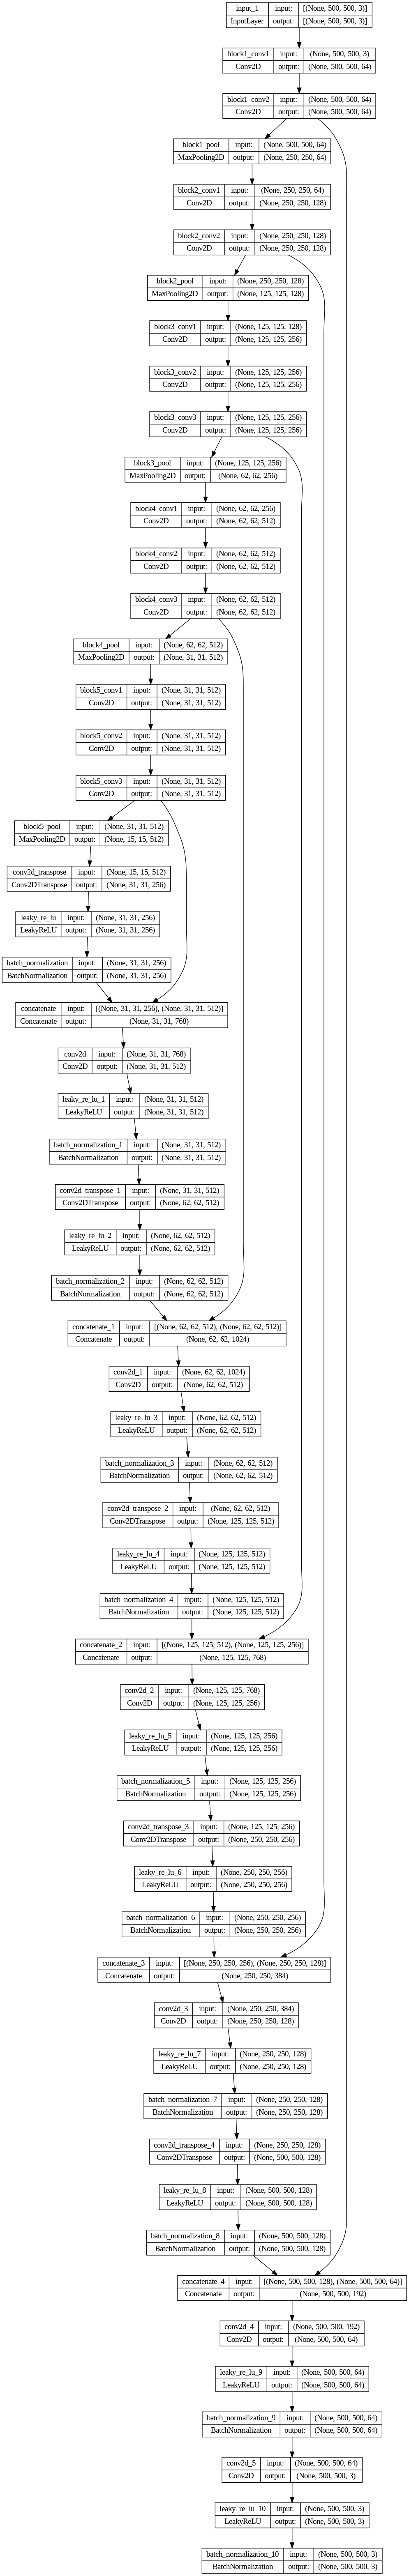

In [ ]:
import keras.utils
from keras.utils import plot_model
plot_model(Model_,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

In [ ]:
import keras.backend as K

In [ ]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [ ]:
def dice_coef(y_true, y_pred):
    #print(y_true_f.shape,y_pred_f.shape)
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection = K.sum(y_true_f * y_pred_f.astype(np.float32))
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    #print(y_true.shape,y_pred.shape)
    return -dice_coef(y_true, y_pred)


In [ ]:
def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        y_input = y[i].reshape(1,500,500,3)
        yield (X_input,y_input)
def GenerateInputsVal(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        y_input = y[i].reshape(1,500,500,3)
        return (X_input,y_input)

In [ ]:
L = 250

X_tr = X_[:L]
y_tr = y_[:L]

X_val = X_[L:]
y_val = y_[L:]

In [ ]:
import itertools

In [ ]:
itertools.cycle([X_val,y_val])

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=4, dim=(500,500,3), n_channels=1,
                 shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        #print(X.shape,y.shape)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty(( self.batch_size,self.n_channels, *self.dim))
        y = np.empty(( self.batch_size,self.n_channels, *self.dim))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            #X[i,] = np.load('data/' + ID + '.npy')
            X[i] = self.list_IDs[i].reshape(1,500,500,3)

            # Store class
            #y[i] = self.labels[ID]
            y[i] = self.labels[i].reshape(1,500,500,3)

        return X[0], y[0]

In [ ]:
# Parameters
params = {'dim': (500,500,3),
          'batch_size': 1,
          'n_channels': 1,
          'shuffle': True}


# Generators
training_generator = DataGenerator(X_tr, y_tr, **params)
validation_generator = DataGenerator(X_val, y_val, **params)

In [ ]:
validation_generator.__getitem__(0)[1].shape


(1, 500, 500, 3)

In [ ]:
#checkpointer = ModelCheckpoint('model_TL_UNET_10.h5', verbose=1,mode='auto', monitor='loss',save_best_only=True)

In [ ]:
checkpointer = ModelCheckpoint('model_TL_UNET_12.h5', verbose=1,mode='auto', monitor='dice_coef',save_best_only=True)

In [ ]:
Model_.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-6),
              loss=dice_coef_loss,
              metrics=[dice_coef,'binary_accuracy'])

In [ ]:
Model_ = load_model('/content/drive/MyDrive/LungSegmentationData/model_TL_UNET_12.h5',
    custom_objects={"dice_coef": dice_coef, "dice_coef_loss": dice_coef_loss},)

In [ ]:
#Model_.compile(optimizer = Adam(learning_rate = 1e-5), loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

In [ ]:
history1 = Model_.fit(training_generator,epochs=40,verbose=1,callbacks=[checkpointer],
                     steps_per_epoch=2,shuffle=True, validation_data =validation_generator)

Epoch 1/40
2/2 [==============================] - ETA: 0s - loss: 0.2899 - dice_coef: -0.2899 - binary_accuracy: 0.5967 
Epoch 1: dice_coef improved from inf to -0.28991, saving model to model_TL_UNET_12.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 292s 246s/step - loss: 0.2899 - dice_coef: -0.2899 - binary_accuracy: 0.5967 - val_loss: -10.9347 - val_dice_coef: 10.9347 - val_binary_accuracy: 0.3065
Epoch 2/40
2/2 [==============================] - ETA: 0s - loss: 0.2013 - dice_coef: -0.2013 - binary_accuracy: 0.6296 
Epoch 2: dice_coef did not improve from -0.28991
2/2 [==============================] - 274s 238s/step - loss: 0.2013 - dice_coef: -0.2013 - binary_accuracy: 0.6296 - val_loss: -7.5237 - val_dice_coef: 7.5237 - val_binary_accuracy: 0.4030
Epoch 3/40
2/2 [==============================] - ETA: 0s - loss: 0.1222 - dice_coef: -0.1222 - binary_accuracy: 0.6448 
Epoch 3: dice_coef did not improve from -0.28991
2/2 [==============================] - 276s 237s/step - loss: 0.1222 - dice_coef: -0.1222 - binary_accuracy: 0.6448 - val_loss: -5.5250 - val_dice_coef: 5.5250 - val_binary_accuracy: 0.4309
Epoch 4/40
2/2 [==============================] - ETA: 0s - loss: 0.0442 - dice_coef: -0

In [ ]:
history1 = Model_.fit(training_generator,epochs=40,verbose=1,callbacks=[checkpointer],
                     steps_per_epoch=2,shuffle=True, validation_data =validation_generator)

Epoch 1/40
2/2 [==============================] - ETA: 0s - loss: -0.2512 - dice_coef: 0.2512 - binary_accuracy: 0.6623 
Epoch 1: dice_coef did not improve from -0.41044
2/2 [==============================] - 282s 238s/step - loss: -0.2512 - dice_coef: 0.2512 - binary_accuracy: 0.6623 - val_loss: -3.6021 - val_dice_coef: 3.6021 - val_binary_accuracy: 0.2794
Epoch 2/40
2/2 [==============================] - ETA: 0s - loss: -0.2579 - dice_coef: 0.2579 - binary_accuracy: 0.6621 
Epoch 2: dice_coef did not improve from -0.41044
2/2 [==============================] - 275s 239s/step - loss: -0.2579 - dice_coef: 0.2579 - binary_accuracy: 0.6621 - val_loss: -3.4298 - val_dice_coef: 3.4298 - val_binary_accuracy: 0.2863
Epoch 3/40
2/2 [==============================] - ETA: 0s - loss: -0.2644 - dice_coef: 0.2644 - binary_accuracy: 0.6620 
Epoch 3: dice_coef did not improve from -0.41044
2/2 [==============================] - 274s 237s/step - loss: -0.2644 - dice_coef: 0.2644 - binary_accuracy: 0

In [ ]:
history1 = Model_.fit(training_generator,epochs=20,verbose=1,callbacks=[checkpointer],
                     steps_per_epoch=2,shuffle=True, validation_data =validation_generator)

Epoch 1/20
2/2 [==============================] - ETA: 0s - loss: 0.1930 - dice_coef: -0.1930 - binary_accuracy: 0.5660 
Epoch 1: dice_coef did not improve from -0.19300
2/2 [==============================] - 263s 223s/step - loss: 0.1930 - dice_coef: -0.1930 - binary_accuracy: 0.5660 - val_loss: 0.4593 - val_dice_coef: -0.4593 - val_binary_accuracy: 0.6638
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 0.1707 - dice_coef: -0.1707 - binary_accuracy: 0.5684 
Epoch 2: dice_coef did not improve from -0.19300
2/2 [==============================] - 259s 221s/step - loss: 0.1707 - dice_coef: -0.1707 - binary_accuracy: 0.5684 - val_loss: 0.3491 - val_dice_coef: -0.3491 - val_binary_accuracy: 0.6527
Epoch 3/20
2/2 [==============================] - ETA: 0s - loss: 0.1468 - dice_coef: -0.1468 - binary_accuracy: 0.5719 
Epoch 3: dice_coef did not improve from -0.19300
2/2 [==============================] - 259s 223s/step - loss: 0.1468 - dice_coef: -0.1468 - binary_accuracy: 0

In [ ]:
history1 = Model_.fit(training_generator,epochs=20,verbose=1,callbacks=[checkpointer],
                     steps_per_epoch=2,shuffle=True, validation_data =validation_generator)

Epoch 1/20
2/2 [==============================] - ETA: 0s - loss: -0.0506 - dice_coef: 0.0506 - binary_accuracy: 0.6237 
Epoch 1: dice_coef improved from inf to 0.05055, saving model to model_TL_UNET_11.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 293s 240s/step - loss: -0.0506 - dice_coef: 0.0506 - binary_accuracy: 0.6237 - val_loss: 0.3781 - val_dice_coef: -0.3781 - val_binary_accuracy: 0.6733
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: -0.0677 - dice_coef: 0.0677 - binary_accuracy: 0.6251 
Epoch 2: dice_coef did not improve from 0.05055
2/2 [==============================] - 263s 224s/step - loss: -0.0677 - dice_coef: 0.0677 - binary_accuracy: 0.6251 - val_loss: 0.2946 - val_dice_coef: -0.2946 - val_binary_accuracy: 0.6693
Epoch 3/20
2/2 [==============================] - ETA: 0s - loss: -0.0841 - dice_coef: 0.0841 - binary_accuracy: 0.6259 
Epoch 3: dice_coef did not improve from 0.05055
2/2 [==============================] - 261s 225s/step - loss: -0.0841 - dice_coef: 0.0841 - binary_accuracy: 0.6259 - val_loss: 0.2086 - val_dice_coef: -0.2086 - val_binary_accuracy: 0.6639
Epoch 4/20
2/2 [==============================] - ETA: 0s - loss: -0.1012 - dice_coef: 0.101

KeyboardInterrupt: 

In [ ]:
history = Model_.fit(training_generator,epochs=20,verbose=1,callbacks=[checkpointer],
                     steps_per_epoch=2,shuffle=True, validation_data =validation_generator)

Epoch 1/20
2/2 [==============================] - ETA: 0s - loss: 0.4250 - dice_coef: -0.4250 - binary_accuracy: 0.5725  
Epoch 1: loss improved from 641.07660 to 0.42495, saving model to model_TL_UNET_10.h5
2/2 [==============================] - 268s 188s/step - loss: 0.4250 - dice_coef: -0.4250 - binary_accuracy: 0.5725 - val_loss: -0.5189 - val_dice_coef: 0.5189 - val_binary_accuracy: 0.4941
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 0.4022 - dice_coef: -0.4022 - binary_accuracy: 0.5768 
Epoch 2: loss improved from 0.42495 to 0.40215, saving model to model_TL_UNET_10.h5
2/2 [==============================] - 228s 191s/step - loss: 0.4022 - dice_coef: -0.4022 - binary_accuracy: 0.5768 - val_loss: -0.2884 - val_dice_coef: 0.2884 - val_binary_accuracy: 0.4940
Epoch 3/20
2/2 [==============================] - ETA: 0s - loss: 0.3784 - dice_coef: -0.3784 - binary_accuracy: 0.5816 
Epoch 3: loss improved from 0.40215 to 0.37835, saving model to model_TL_UNET_10.h5
2/

In [ ]:
tf.random.set_seed(0)

In [ ]:
pred_ = cv.resize(X_[0],(500,500))
plt.imshow((pred_ * 255).astype(np.uint8))

In [ ]:
history = Model_.fit(GenerateInputs(X_tr,y_tr),epochs=20,verbose=1,callbacks=[checkpointer],
                     steps_per_epoch=2,shuffle=True, validation_data = GenerateInputs(X_val,y_val))

Epoch 1/20
2/2 [==============================] - ETA: 0s - loss: 0.2534 - binary_accuracy: 0.5699 
Epoch 1: loss improved from inf to 0.25344, saving model to model_TL_UNET_8.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 1087s 1029s/step - loss: 0.2534 - binary_accuracy: 0.5699 - val_loss: -9.1269 - val_binary_accuracy: 0.4828
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 0.1109 - binary_accuracy: 0.5546 


Epoch 2: loss improved from 0.25344 to 0.11093, saving model to model_TL_UNET_8.h5
2/2 [==============================] - 91s 49s/step - loss: 0.1109 - binary_accuracy: 0.5546
Epoch 3/20
2/2 [==============================] - ETA: 0s - loss: -0.2302 - binary_accuracy: 0.5789 
Epoch 3: loss improved from 0.11093 to -0.23017, saving model to model_TL_UNET_8.h5
2/2 [==============================] - 90s 49s/step - loss: -0.2302 - binary_accuracy: 0.5789
Epoch 4/20
2/2 [==============================] - ETA: 0s - loss: -0.3333 - binary_accuracy: 0.5720 
Epoch 4: loss improved from -0.23017 to -0.33330, saving model to model_TL_UNET_8.h5
2/2 [==============================] - 90s 50s/step - loss: -0.3333 - binary_accuracy: 0.5720
Epoch 5/20
2/2 [==============================] - ETA: 0s - loss: -0.6311 - binary_accuracy: 0.5878 
Epoch 5: loss improved from -0.33330 to -0.63106, saving model to model_TL_UNET_8.h5
2/2 [==============================] - 90s 50s/step - loss: -0.6311 - binary_a

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 89s 49s/step - loss: -3.1469 - binary_accuracy: 0.7009


In [ ]:
history = Model_.fit(GenerateInputs(X_tr,y_tr),epochs=25,verbose=1,callbacks=[checkpointer],
                     steps_per_epoch=2,shuffle=True, validation_data = GenerateInputs(X_val,y_val))

Epoch 1/25
2/2 [==============================] - ETA: 0s - loss: -3.1766 - binary_accuracy: 0.7012 
Epoch 1: loss improved from inf to -3.17661, saving model to model_TL_UNET_9.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 1006s 968s/step - loss: -3.1766 - binary_accuracy: 0.7012 - val_loss: -17.2246 - val_binary_accuracy: 0.3554
Epoch 2/25
2/2 [==============================] - ETA: 0s - loss: -3.1916 - binary_accuracy: 0.7013 


Epoch 2: loss improved from -3.17661 to -3.19164, saving model to model_TL_UNET_9.h5
2/2 [==============================] - 87s 49s/step - loss: -3.1916 - binary_accuracy: 0.7013
Epoch 3/25
2/2 [==============================] - ETA: 0s - loss: -3.2180 - binary_accuracy: 0.7015 
Epoch 3: loss improved from -3.19164 to -3.21801, saving model to model_TL_UNET_9.h5
2/2 [==============================] - 90s 52s/step - loss: -3.2180 - binary_accuracy: 0.7015
Epoch 4/25
2/2 [==============================] - ETA: 0s - loss: -3.2341 - binary_accuracy: 0.7029 
Epoch 4: loss improved from -3.21801 to -3.23410, saving model to model_TL_UNET_9.h5
2/2 [==============================] - 88s 48s/step - loss: -3.2341 - binary_accuracy: 0.7029
Epoch 5/25
2/2 [==============================] - ETA: 0s - loss: -3.2498 - binary_accuracy: 0.7035 
Epoch 5: loss improved from -3.23410 to -3.24977, saving model to model_TL_UNET_9.h5
2/2 [==============================] - 91s 52s/step - loss: -3.2498 - bina

KeyboardInterrupt: 

In [ ]:
Model_ = load_model('/content/drive/MyDrive/LungSegmentationData/model_TL_UNET_6.h5',
    custom_objects={"dice_coef": dice_coef, "dice_coef_loss": dice_coef_loss},)

1/1 [==============================] - 12s 12s/step


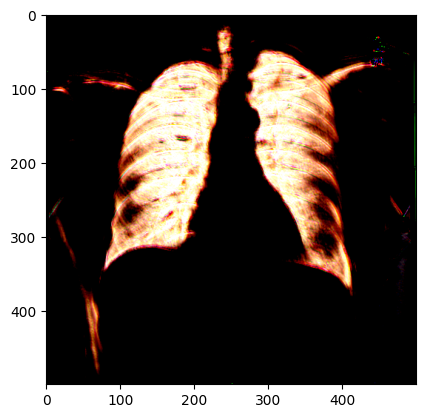

In [ ]:
img_x = cv.imread("/content/drive/MyDrive/input_c/segmentation/train/image/CHNCXR_0017_0.png")
plt.imshow(img_x)
#img_x = cv.cvtColor(img_x, cv.COLOR_BGR2RGB)
img_x = cv.resize(img_x,(500,500))
img_x = img_x.reshape(1,500,500,3)
prediction = Model_.predict(img_x)
pred_ = prediction.reshape(500,500,3)
#pred_ = np.average(pred_, 2)
#pred_ = cv.resize(pred,(700,450))
#pred_ = np.where(pred_<np.median(pred_),0,255)
#pred_ = np.where(pred_<0,0,pred_)
#pred_ = np.where(pred_>120,255,pred_)
plt.imshow(pred_)
#plt.imshow(pred_)

In [ ]:
TransferLearningModel = load_model('model_TL_UNET_2.h5',
    custom_objects={"dice_coef": dice_coef, "dice_coef_loss": dice_coef_loss},)

(512, 512, 3)


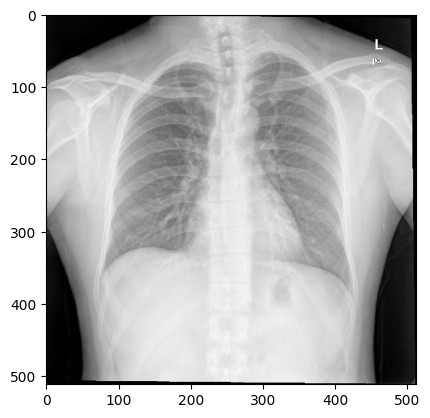

In [ ]:
img_x = cv.imread("/content/drive/MyDrive/input_c/segmentation/train/image/CHNCXR_0017_0.png")
print(img_x.shape)
plt.imshow(img_x)
#img_x = cv.cvtColor(img_x, cv.COLOR_BGR2RGB)
img_x = cv.resize(img_x,(500,500))
img_x = img_x.reshape(1,500,500,3)

1/1 [==============================] - 11s 11s/step


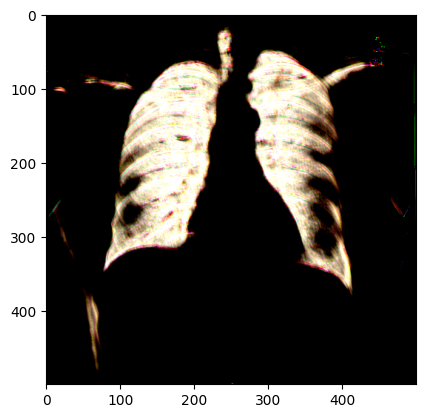

In [ ]:
prediction = Model_.predict(img_x)
pred_ = prediction.reshape(500,500,3)
#pred_ = np.average(pred_, 2)
#pred_ = cv.resize(pred,(700,450))
#pred_ = np.where(pred_<np.median(pred_),0,255)
#pred_ = np.where(pred_<0,0,pred_)
#pred_ = np.where(pred_>120,255,pred_)
plt.imshow(pred_)
#plt.imshow(pred_)

(224, 224, 3)


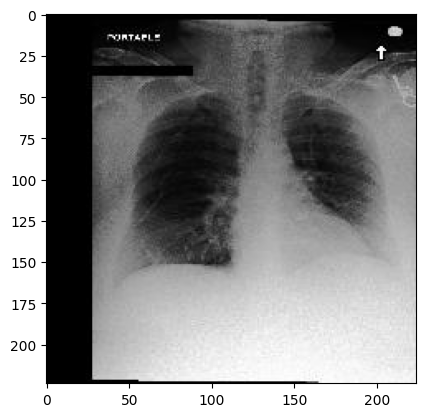

In [ ]:
img_x = cv.imread("/content/00025932.pkl_17585185_20442953.0_34.jpg")
print(img_x.shape)
plt.imshow(img_x)
#img_x = cv.cvtColor(img_x, cv.COLOR_BGR2RGB)
img_x = cv.resize(img_x,(500,500))
img_x = img_x.reshape(1,500,500,3)

1/1 [==============================] - 10s 10s/step


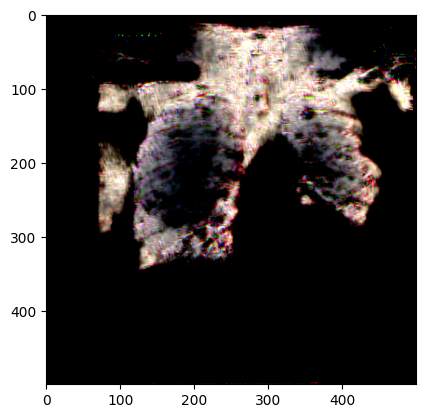

In [ ]:
prediction = Model_.predict(img_x)
pred_ = prediction.reshape(500,500,3)
#pred_ = np.average(pred_, 2)
#pred_ = cv.resize(pred,(700,450))
#pred_ = np.where(pred_<np.median(pred_),0,255)
#pred_ = np.where(pred_<0,0,pred_)
#pred_ = np.where(pred_>120,255,pred_)
plt.imshow(pred_)
#plt.imshow(pred_)

In [ ]:
plt.imshow(pred_[:,:,1])

In [ ]:
plt.imshow(pred_[:,:,2])

In [ ]:
#prediction = Model_.predict(img_x)
pred_ = prediction.reshape(500,500,3)
pred_ = np.where(pred_<100,0,255)
plt.imshow(pred_)
#plt.imshow(pred_)

In [ ]:
prediction = TransferLearningModel.predict(img_x)
pred_ = prediction.reshape(500,500,3)
#pred_ = np.where(pred_<0.2,0,255)
plt.imshow(pred_)
#plt.imshow(pred_)

(224, 224, 3)


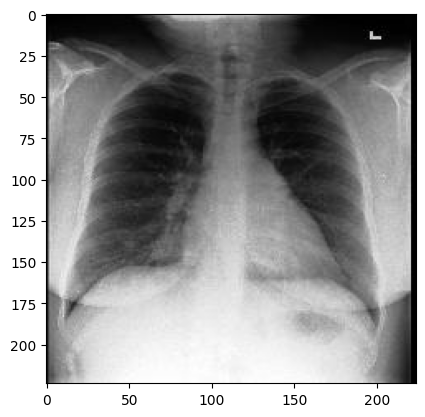

In [ ]:
img_x = cv.imread("/content/00025161.pkl_17368827_25154570.0_0.jpg")
print(img_x.shape)
plt.imshow(img_x)
#img_x = cv.cvtColor(img_x, cv.COLOR_BGR2RGB)
img_x = cv.resize(img_x,(500,500))
img_x = img_x.reshape(1,500,500,3)

1/1 [==============================] - 10s 10s/step


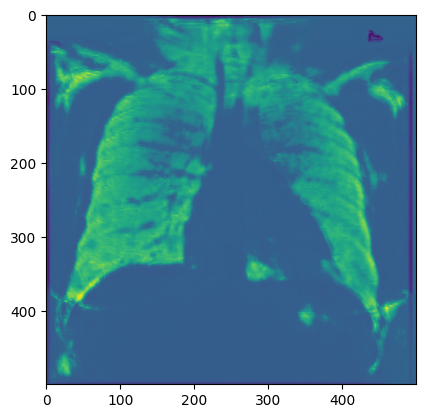

In [ ]:
prediction = Model_.predict(img_x)
pred_ = prediction.reshape(500,500,3)
pred_ = np.average(pred_, 2)
#pred_ = cv.resize(pred,(700,450))
#pred_ = np.where(pred_<np.median(pred_),0,255)
#pred_ = np.where(pred_<0,0,pred_)
#pred_ = np.where(pred_>100,255,pred_)
plt.imshow(pred_)
#plt.imshow(pred_)

(512, 512, 3)
1/1 [==============================] - 8s 8s/step


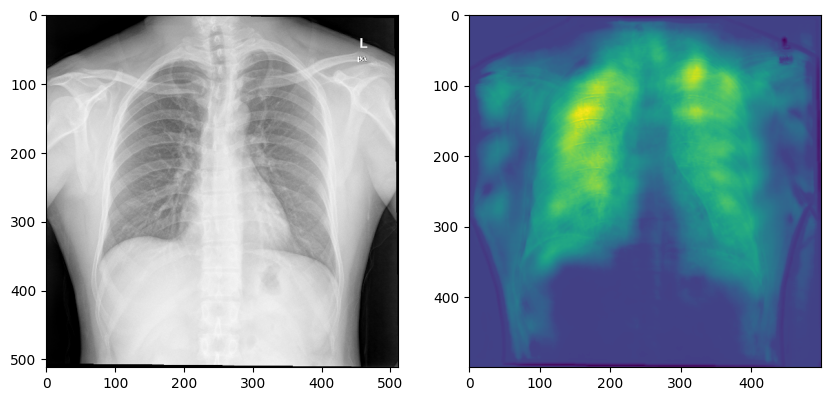

In [ ]:
fig = plt.figure(figsize=(10, 7))
img_x = cv.imread("/content/drive/MyDrive/input_c/segmentation/train/image/CHNCXR_0017_0.png")
print(img_x.shape)
fig.add_subplot(1, 2, 1)
plt.imshow(img_x)

img_x = cv.resize(img_x,(500,500))
img_x = img_x.reshape(1,500,500,3)
prediction = Model_.predict(img_x)
pred_ = prediction.reshape(500,500,3)
pred_ = np.average(pred_, 2)
fig.add_subplot(1, 2, 2)
plt.imshow(pred_)

(512, 512, 3)
1/1 [==============================] - 9s 9s/step


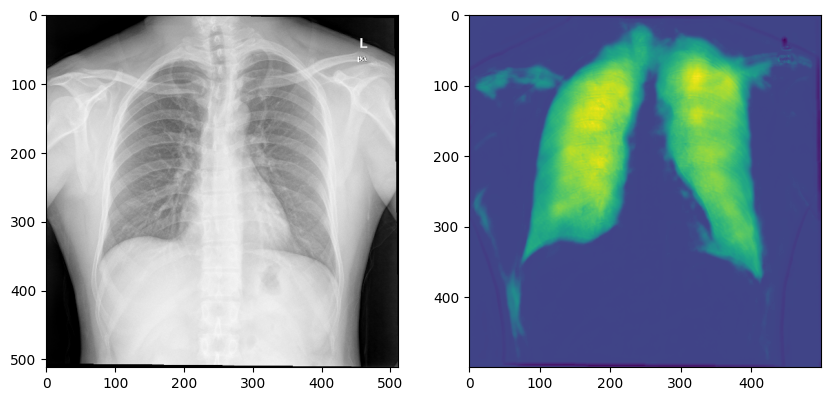

In [ ]:
fig = plt.figure(figsize=(10, 7))
img_x = cv.imread("/content/drive/MyDrive/input_c/segmentation/train/image/CHNCXR_0017_0.png")
print(img_x.shape)
fig.add_subplot(1, 2, 1)
plt.imshow(img_x)

img_x = cv.resize(img_x,(500,500))
img_x = img_x.reshape(1,500,500,3)
prediction = Model_.predict(img_x)
pred_ = prediction.reshape(500,500,3)
pred_ = np.average(pred_, 2)
fig.add_subplot(1, 2, 2)
plt.imshow(pred_)

(224, 224, 3)
1/1 [==============================] - 8s 8s/step


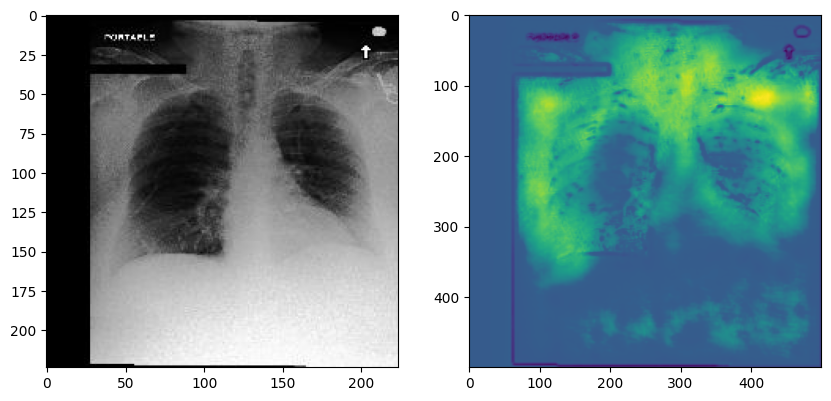

In [ ]:
fig = plt.figure(figsize=(10, 7))
img_x = cv.imread("/content/00025932.pkl_17585185_20442953.0_34.jpg")
print(img_x.shape)
fig.add_subplot(1, 2, 1)
plt.imshow(img_x)

img_x = cv.resize(img_x,(500,500))
img_x = img_x.reshape(1,500,500,3)
prediction = Model_.predict(img_x)
pred_ = prediction.reshape(500,500,3)
pred_ = np.average(pred_, 2)
fig.add_subplot(1, 2, 2)
plt.imshow(pred_)

(224, 224, 3)
1/1 [==============================] - 9s 9s/step


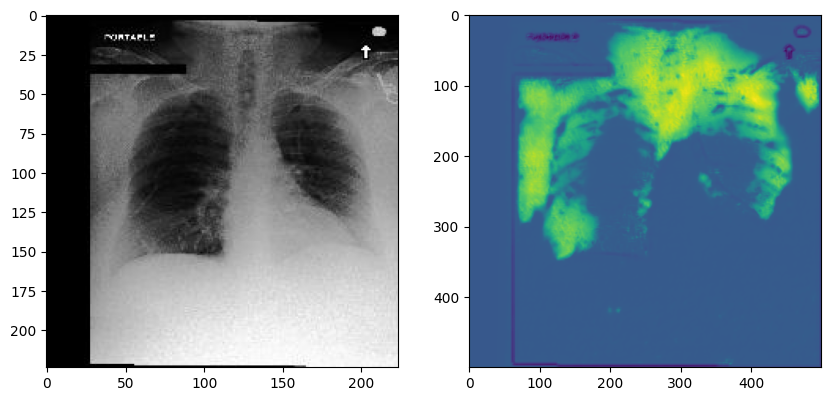

In [ ]:
fig = plt.figure(figsize=(10, 7))
img_x = cv.imread("/content/00025932.pkl_17585185_20442953.0_34.jpg")
print(img_x.shape)
fig.add_subplot(1, 2, 1)
plt.imshow(img_x)

img_x = cv.resize(img_x,(500,500))
img_x = img_x.reshape(1,500,500,3)
prediction = Model_.predict(img_x)
pred_ = prediction.reshape(500,500,3)
pred_ = np.average(pred_, 2)
fig.add_subplot(1, 2, 2)
plt.imshow(pred_)

(224, 224, 3)
1/1 [==============================] - 10s 10s/step


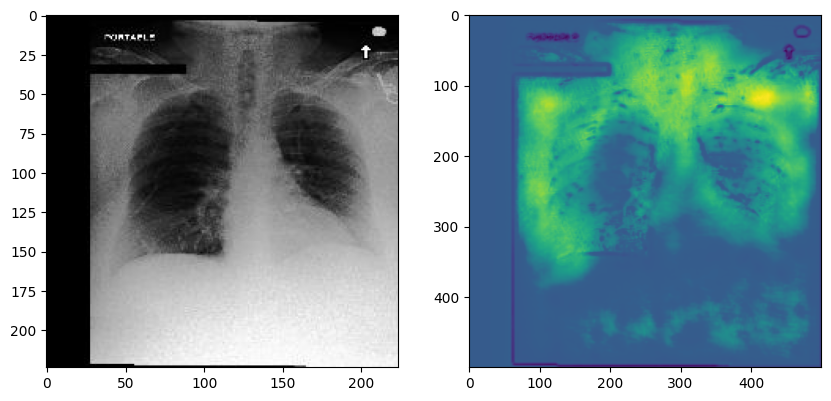

In [ ]:
fig = plt.figure(figsize=(10, 7))
img_x = cv.imread("/content/00025932.pkl_17585185_20442953.0_34.jpg")
print(img_x.shape)
fig.add_subplot(1, 2, 1)
plt.imshow(img_x)

img_x = cv.resize(img_x,(500,500))
img_x = img_x.reshape(1,500,500,3)
prediction = Model_.predict(img_x)
pred_ = prediction.reshape(500,500,3)
pred_ = np.average(pred_, 2)
fig.add_subplot(1, 2, 2)
plt.imshow(pred_)

(224, 224, 3)
1/1 [==============================] - 10s 10s/step


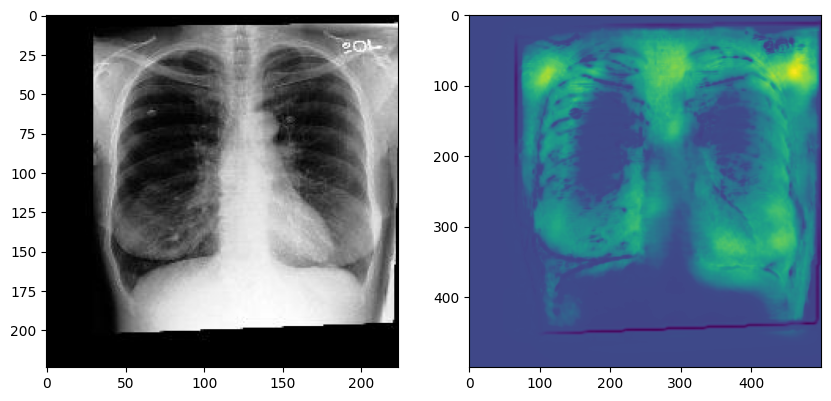

In [ ]:
fig = plt.figure(figsize=(10, 7))
img_x = cv.imread("/content/00007798.pkl_12270337_20245737.0_5.jpg")
print(img_x.shape)
fig.add_subplot(1, 2, 1)
plt.imshow(img_x)

img_x = cv.resize(img_x,(500,500))
img_x = img_x.reshape(1,500,500,3)
prediction = Model_.predict(img_x)
pred_ = prediction.reshape(500,500,3)
pred_ = np.average(pred_, 2)
fig.add_subplot(1, 2, 2)
plt.imshow(pred_)

(224, 224, 3)
1/1 [==============================] - 9s 9s/step


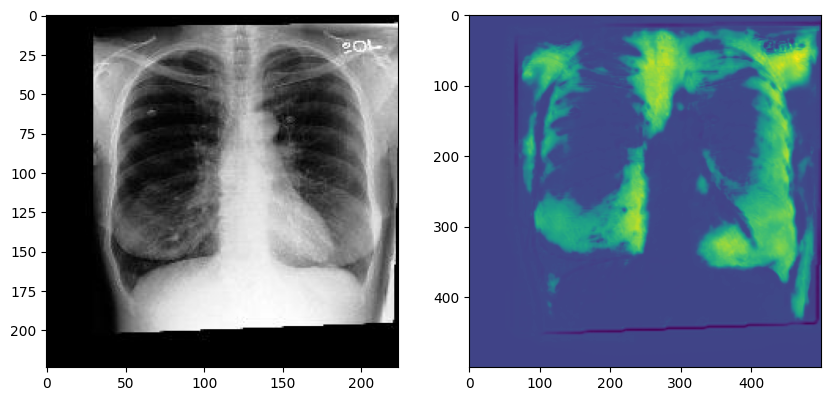

In [ ]:
fig = plt.figure(figsize=(10, 7))
img_x = cv.imread("/content/00007798.pkl_12270337_20245737.0_5.jpg")
print(img_x.shape)
fig.add_subplot(1, 2, 1)
plt.imshow(img_x)

img_x = cv.resize(img_x,(500,500))
img_x = img_x.reshape(1,500,500,3)
prediction = Model_.predict(img_x)
pred_ = prediction.reshape(500,500,3)
pred_ = np.average(pred_, 2)
fig.add_subplot(1, 2, 2)
plt.imshow(pred_)

(224, 224, 3)
1/1 [==============================] - 9s 9s/step


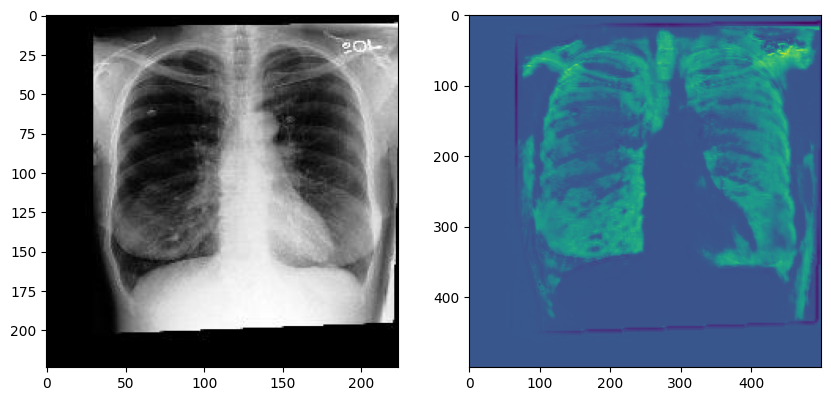

In [ ]:
fig = plt.figure(figsize=(10, 7))
img_x = cv.imread("/content/00007798.pkl_12270337_20245737.0_5.jpg")
print(img_x.shape)
fig.add_subplot(1, 2, 1)
plt.imshow(img_x)

img_x = cv.resize(img_x,(500,500))
img_x = img_x.reshape(1,500,500,3)
prediction = Model_.predict(img_x)
pred_ = prediction.reshape(500,500,3)
pred_ = np.average(pred_, 2)
fig.add_subplot(1, 2, 2)
plt.imshow(pred_)

(224, 224, 3)
1/1 [==============================] - 8s 8s/step


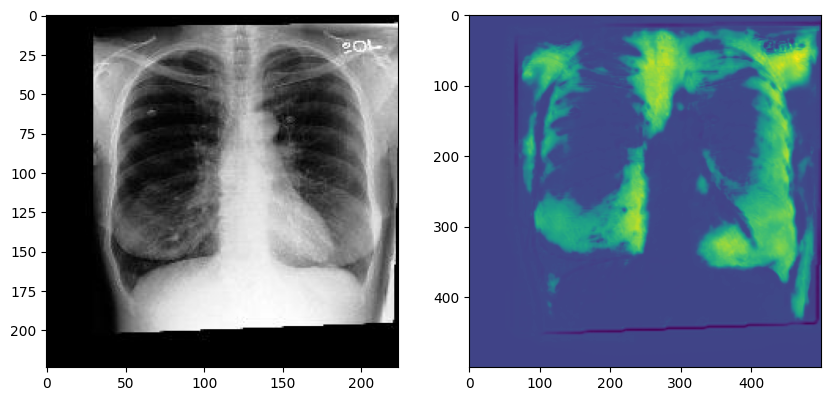

In [ ]:
fig = plt.figure(figsize=(10, 7))
img_x = cv.imread("/content/00007798.pkl_12270337_20245737.0_5.jpg")
print(img_x.shape)
fig.add_subplot(1, 2, 1)
plt.imshow(img_x)

img_x = cv.resize(img_x,(500,500))
img_x = img_x.reshape(1,500,500,3)
prediction = Model_.predict(img_x)
pred_ = prediction.reshape(500,500,3)
pred_ = np.average(pred_, 2)
fig.add_subplot(1, 2, 2)
plt.imshow(pred_)

(224, 224, 3)
1/1 [==============================] - 10s 10s/step


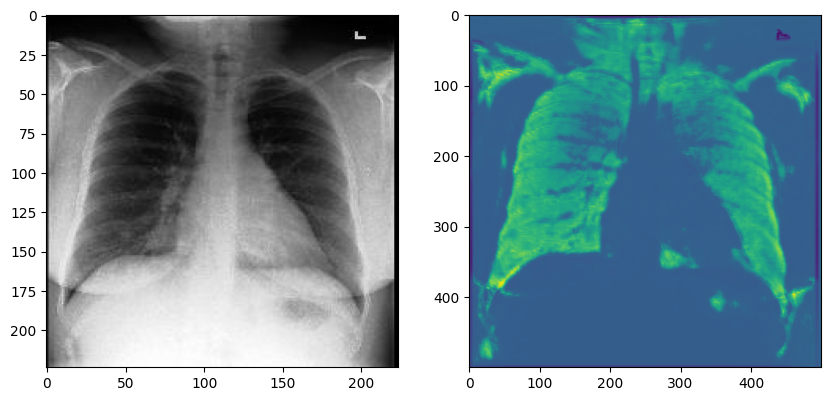

In [ ]:
fig = plt.figure(figsize=(10, 7))
img_x = cv.imread("/content/00025161.pkl_17368827_25154570.0_0.jpg")
print(img_x.shape)
fig.add_subplot(1, 2, 1)
plt.imshow(img_x)

img_x = cv.resize(img_x,(500,500))
img_x = img_x.reshape(1,500,500,3)
prediction = Model_.predict(img_x)
pred_ = prediction.reshape(500,500,3)
pred_ = np.average(pred_, 2)
fig.add_subplot(1, 2, 2)
plt.imshow(pred_)